# Modelling Simple Harmonic Jitter
The goal here is to model the effect of jitter (instability in the pointing of a telescope) on the image. Here we will assume that the telescope is vibrating at high frequency back and forth in one-dimension, following a simple harmonic motion. One would expect the result of this jitter to appear like a blur with two peaks at the extremity of its excursion, as that is the position at which the detector spends the most time during its exposure. Let us derive analytically what that function looks like.

For now, let's just work in one-dimension. Eventually we are going to want to model this by creating a convolution kernel of this weird peaky function, and convolve it with our stable image. So one-dimension works for now, as we can extrapolate to two-dimensions by hitting our one-dimensional result with a rotation matrix.

The telescope point is varying according to simple harmonic motion (SHM):

$$ x(t) = A\sin(t), $$

with inverse function (will be important later):

$$ t(x) = \arcsin(x/A). $$

We will ignore the frequency as we are assuming a single period is significantly shorter than the detector integration time. The convolution kernel will be the probability distribution function (PDF) of this SHM. This makes sense, as the PDF is proportional to how long the telescope spends in each part of the oscillation path. 

We can consider a random variable $X$, representing the position of telescope pointing, which has a PDF of $f(x)$:

$$ P(-A < X < A) = \int_{-A}^{A}f(x) \, dx = A\sin(t). $$

We want to find this function $f(x)$. Since we consider the income of photons to be approximately uniform in time, we can similarly consider a random variable $T$ representing time sampling with a PDF of $g(t)=1/2\pi$, as $2\pi$ is the period of oscillation:

$$ P(t_1 < T < t_2) = \int_{t_1}^{t_2} g(t) \, dt = \frac{1}{2\pi}\int_{t_1}^{t_2} dt. $$ 

One can transform PDFs using [the following rule](https://www.cl.cam.ac.uk/teaching/2003/Probability/prob11.pdf):

$$ f(x) = g(t(x))\left|{\frac{dt}{dx}}\right|. $$

Substituting in $g(t)=2\pi$ and given the [derivative of $ \arcsin(x/A) $](https://www.google.com/), we are left with:

$$ f(x) = \frac{1}{2\pi\sqrt{A^2 - x^2}}. $$

Great. This equation is our PDF of the telescope pointing position, and thus the functional form of our desired convolution kernel.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

To convince ourselves of this, let's generate some uniformly distributed samples over $[-\pi/2, \pi/2]$ and pass them through a sinusoid. We can then plot the histogram to approximate the PDF.

In [28]:
# Simple harmonic motion
def x(t, A):
    return A*np.sin(t)

# derived probability density function
def f(x, A):
    return 1/(2*np.pi*np.sqrt(A**2 - x**2))

/var/folders/7d/c7wd3zcx3dlc6fmsmqwykh0m0000gn/T/ipykernel_30369/1617483462.py:5: RuntimeWarning: divide by zero encountered in divide
  return 1/(2*np.pi*np.sqrt(A**2 - x**2))


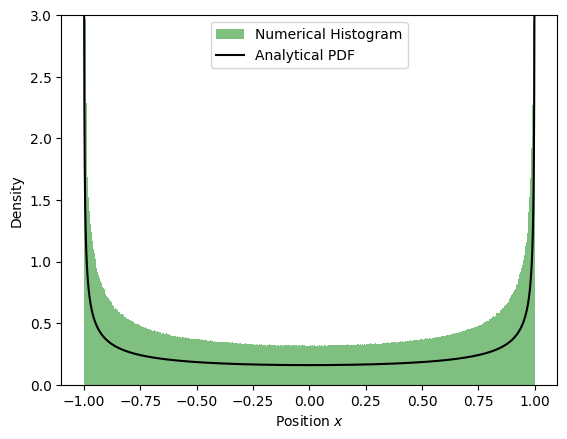

In [4]:
A = 1
time_samples = np.random.uniform(-np.pi/2, np.pi/2, 10000000)
position_samples = np.linspace(-A, A, 10000)

hist_outputs = CDF(time_samples, A)
PDF_outputs = PDF(position_samples, A)

fig, ax = plt.subplots()
ax.hist(hist_outputs, bins=500, density=True, alpha=0.5, label='Numerical Histogram', color='green')
ax.plot(position_samples, PDF_outputs, c='k', label='Analytical PDF')
ax.legend()
ax.set(ylim=(None, 3), xlabel='Position $x$', ylabel='Density')
plt.show()

We can see the shape of the curves are the same -- they are identical to within a normalisation factor.

We want to represent this function on a pixel grid

In [25]:
from dLux.utils import nd_coords

pscale = 0.19
npix = int(np.ceil(2*A / pscale))
print(f"npix = {npix}")

pixel_centres = nd_coords(npixels=npix, pixel_scales=pscale)
pixel_edges = nd_coords(npixels=npix+1, pixel_scales=pscale)

npix = 11


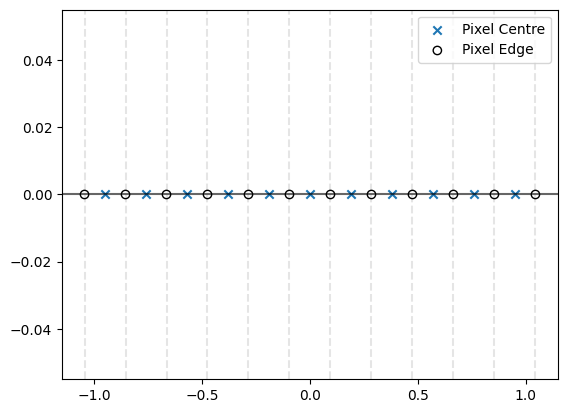

In [26]:
fig, ax = plt.subplots()
ax.scatter(pixel_centres, np.zeros(npix), marker='x', label="Pixel Centre")
ax.scatter(pixel_edges,  np.zeros(npix+1), marker='o', facecolors='none', edgecolors='k', label="Pixel Edge")
# ax.set(
#     xlim=(-pscale*npix/2, pscale*npix/2),
#     ylim=(-pscale*npix/2, pscale*npix/2),
#     xlabel='x',
#     ylabel='y',
# )

for edge in pixel_edges:
    ax.axvline(edge, c='k', linestyle='--', alpha=0.1)
ax.axhline(0, c='k', linestyle='-', alpha=0.6)
ax.legend()
# ax.scatter(hist_outputs[::5000], np.zeros(hist_outputs[::5000].shape), alpha=0.002, c='k')
plt.show()